# Networks: AMP-PD PPMI x PDBP - January 2021
 - **Project:** Build networks based on underlying data and Mary's feature importance.
 - **Author(s):** Mary Makarious, Dan Vitale, Faraz Faghri, Mike Nalls 

---
### Quick Description: 
- **Problem:** These genetic features are important, are then new networks / communities? 
- **Solution:** The list below sums it up well ...  

1.   Pull genes - this includes querying QTLs from open targets API in brain tissues to connect SNPs to genes.
2.   Extract from AMP data.
3.   Build correlation / graph space in cases.
4.   Leiden to build communties.
5.   Vizualize.




# Imports and set up.

In [ ]:
# Imports and set up of the colab.
import os
from google.colab import drive
import pandas.util.testing as tm
import h5py
import numpy as np
import pandas as pd
import math
import sys
import joblib
import subprocess
import statsmodels.api as sm
from scipy import stats

! pip install --upgrade tables
import tables

drive.mount('/content/drive/')
os.chdir("/content/drive/Shared drives/LNG/users/makariousmb/projects/PPMIxPDBP_GenoML/mike_networks")
! pwd

import requests
import pandas as pd
import json

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


     |████████████████████████████████| 4.3MB 8.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


# Pull the genes of interest from the feature importance file.

Read in features and extract the 'ENSG' to one list and rsIDs to another.

In [ ]:
# Quick and dirty styles.
! grep 'ENSG' validate-PDBP-genetic_p1E5_omic_p1E2.list_features.txt > rna_from_impMat.txt
! grep 'rs' validate-PDBP-genetic_p1E5_omic_p1E2.list_features.txt > SNPs_from_impMat_temp.txt
! cat SNPs_from_impMat_temp.txt GWAS_hit_list_PD.csv > snps_from_impMat.txt

In [ ]:
# API calls set up.

def search_rsid_open_targets_query(rsid):

  """
  query open targets for snp ids in chr_pos_a1_a2 and allele freqs with rsid

  input: rsid
  output: ids and allele frequencies for different ancestry groups with columns:
  id	rsId	gnomadAFR	gnomadAMR	gnomadASJ	gnomadEAS	gnomadFIN	gnomadNFE	
    gnomadNFEEST	gnomadNFENWE	gnomadNFESEU	gnomadNFEONF	gnomadOTH

  Some information on the allele frequencies being pulled 

  "gnomAD Allele frequency (African/African-American population)"
    gnomadAFR: Float

    "gnomAD Allele frequency (Latino/Admixed American population)"
    gnomadAMR: Float

    "gnomAD Allele frequency (Ashkenazi Jewish population)"
    gnomadASJ: Float

    "gnomAD Allele frequency (East Asian population)"
    gnomadEAS: Float

    "gnomAD Allele frequency (Finnish population)"
    gnomadFIN: Float

    "gnomAD Allele frequency (Non-Finnish European population)"
    gnomadNFE: Float

    "gnomAD Allele frequency (Non-Finnish Eurpoean Estonian sub-population)"
    gnomadNFEEST: Float

    "gnomAD Allele frequency (Non-Finnish Eurpoean North-Western European sub-population)"
    gnomadNFENWE: Float

    "gnomAD Allele frequency (Non-Finnish Eurpoean Southern European sub-population)"
    gnomadNFESEU: Float

    "gnomAD Allele frequency (Non-Finnish Eurpoean Other non-Finnish European sub-population)"
    gnomadNFEONF: Float

    "gnomAD Allele frequency (Other (population not assigned) population)"
    gnomadOTH: Float
    """

  api_query = """
  query search($queryString: String!){
    search(queryString: $queryString) {
      variants{
        id
        rsId
        gnomadAFR
        gnomadAMR
        gnomadASJ
        gnomadEAS
        gnomadFIN
        gnomadNFE
        gnomadNFEEST
        gnomadNFENWE
        gnomadNFESEU
        gnomadNFEONF
        gnomadOTH
      }
    }
  }"""

  #set base_url for Open Targets Genetics Portal API
  base_url = "http://genetics-api.opentargets.io/graphql"
  #set variables object
  variables = {"queryString": rsid}

  #perform API call and check status code of response
  r = requests.post(base_url, json={'query':api_query, "variables":variables})
  if str(r.status_code) == '400':
    print(f'{rsid} query status code: {r.status_code}')
  
  else:
    pass

  #transform API response into JSON 
  api_response_as_json = json.loads(r.text)
  
  return api_response_as_json

def query_qtls(snp_list):
  """
  uses qtl_coloc_open_targets_query() function to query open targets for qtls
    given a list of snps in chr_pos_a1_a2 format (hg38)

  input: list of snps (chr_pos_a1_a2 formatted with hg38 positions)
  output: cleaned up dataframe of qtls with following columns:
  snp	gene_symbol	gene_id	type	tissue	beta	pval
  """

  total_qtls_df = pd.DataFrame()
  for snp in snp_list:
    qtl_query = qtl_coloc_open_targets_query(snp)
    qtl_query_df = pd.json_normalize(qtl_query['data']['genesForVariant'])
    if len(qtl_query_df) !=  0:
      qtl_query_df['snp'] = snp
      qtls_df = qtl_query_df.loc[qtl_query_df.qtls.map(lambda d: len(d)) > 0].reset_index(drop=True).copy()
      total_qtls_df = total_qtls_df.append(qtls_df)
  total_qtls_df = total_qtls_df.reset_index(drop=True)

  final_qtls_df = pd.DataFrame()
  for i, qtl in enumerate(total_qtls_df.qtls):
    for j, qt in enumerate(qtl):
      for k, tissue in enumerate(qt['tissues']):

        qtl_dict = {
            'snp': total_qtls_df.loc[i,'snp'],
            'gene_symbol': total_qtls_df.loc[i,'gene.symbol'],
            'gene_id': total_qtls_df.loc[i,'gene.id'],
            'type': qt['typeId'],
            'tissue': tissue['tissue']['name'],
            'beta': tissue['beta'],
            'pval': tissue['pval']
        }
        
        qtl_dict_df = pd.DataFrame.from_records([qtl_dict])
        final_qtls_df = final_qtls_df.append(qtl_dict_df).reset_index(drop=True)
        
  return final_qtls_df

  
def qtl_coloc_open_targets_query(variant_id):
  """
  queries open targets for qtl data given variant_id in chr_pos_a1_a2 format 
    (hg38)

  input: variant id in chr_pos_a1_a2 format (hg38)
  output: dataframe with the following columns:
  qtls gene.symbol gene.id
  """
  api_query = f'''query {{
    genesForVariant(variantId: "{variant_id}") {{
      gene {{
        id
        symbol
      }}
      qtls{{
        typeId
        sourceId
        aggregatedScore
        tissues{{
          tissue {{
            id
            name
          }}
          quantile
          beta
          pval
        }}
      }}
    }}
  }}'''

  #set base_url for Open Targets Genetics Portal API
  base_url = "http://genetics-api.opentargets.io/graphql"

  #perform API call and check status code of response
  r = requests.post(base_url, json={'query': api_query})
  if str(r.status_code) == '400':
    print(f'{variant_id} query status code: {r.status_code}')
  
  else:
    pass

  #transform API response into JSON 
  api_response_as_json = json.loads(r.text)
  
  return api_response_as_json



Query open targets API. Go from rsID to gr38 ID to filtered gene IDs taken from brain QTLs.

In [ ]:
# Get the variant style IDs as opposed to the rsIDs to query open targets API.

SNP_list_df = pd.read_csv("snps_from_impMat.txt", names=['SNP'])
SNP_list = SNP_list_df['SNP'].unique()

these_SNPs = []

for i in range(len(SNP_list)):
  this_SNP = SNP_list[i]
  rsid_query = search_rsid_open_targets_query(this_SNP)
  rsid_query_df = pd.json_normalize(rsid_query['data']['search']['variants'])
  if hasattr(rsid_query_df, 'id'):
    this_variant_stringed = str(rsid_query_df['id'])
    this_variant = this_variant_stringed.split()[1]
  else:
    this_variant = np.nan
  this_variant = this_variant_stringed.split()[1]
  print(this_SNP, this_variant)
  these_SNPs.append((this_SNP, this_variant))

these_SNPs_df = pd.DataFrame(these_SNPs, columns=('SNP', 'VARIANT'))
these_SNPs_df.to_csv("variants_mined_02112021.csv", index=False)


rs10182170 2_32479118_G_A
rs10186643 2_148046018_G_T
rs1031631 6_69732974_C_T
rs1054972 19_1852583_A_G
rs1057390 2_208494226_C_T
rs10800747 1_200955072_G_T
rs10835060 11_1466913_T_G
rs11042906 11_10643688_C_T
rs11208947 1_66689781_A_G
rs115690633 4_89927124_T_G
rs11743963 5_124915124_C_T
rs12613887 2_28888233_T_C
rs12707530 7_82868656_G_A
rs12928404 16_28835925_T_C
rs12978670 19_2358487_C_T
rs1362443 16_52950779_C_T
rs1444206 12_40682332_G_A
rs1867148 15_75047644_T_C
rs1871900 8_22623936_A_G
rs1900830 2_168122712_C_A
rs2178563 3_54791743_C_T
rs2240331 5_138444679_C_A
rs2247534 8_16858290_G_A
rs2278067 2_95289932_G_T
rs2306241 4_850247_C_T
rs2391256 1_93401378_C_A
rs28370602 12_39953836_G_A
rs2977461 8_140531189_C_T
rs3102347 16_89303461_A_G
rs3821665 3_151416028_G_A
rs4238361 15_61707740_G_T
rs4410769 6_31208469_C_T
rs4427587 11_58669175_T_C
rs4440018 2_134679835_A_G
rs4673341 2_205987662_T_C
rs4752341 10_119698388_G_A
rs4793090 17_42534324_G_A
rs4853705 2_190433047_C_T
rs510257 6_2001

In [ ]:
# Now get the gene IDs for QTLs in brain tissues relating to these SNPs.

these_SNPs_df = pd.read_csv("variants_mined_01072021.csv")
variant_list = these_SNPs_df['VARIANT'].unique()

qtls_df = query_qtls(variant_list)
qtls_df.head()

qtls_df['tissue'].value_counts()

# Subset to blood ... the relevant tissue of interest in this case.

qtls_filtered_df = qtls_df[qtls_df['tissue'] == 'Blood (eQTLGen)']
qtls_filtered_df.describe()

qtls_filtered_df.to_csv("QTLS_mined_02112021.csv", index=False)


Merge the two gene lists and make unique.

In [ ]:
qtls_df = pd.read_csv("QTLS_mined_02112021.csv", engine='c')
rna_df = pd.read_csv("rna_from_impMat.txt", engine='c', names=['gene_id'])

In [ ]:
qtls_df.head()
# qtls_df.describe()

,snp,gene_symbol,gene_id,type,tissue,beta,pval
0,4_47509764_T_C,NFXL1,ENSG00000170448,eqtl,Blood (eQTLGen),0.076645,1.287900e-19
1,18_49054943_G_A,DYM,ENSG00000141627,eqtl,Blood (eQTLGen),0.165194,9.361700e-79
2,4_141027735_T_C,ZNF330,ENSG00000109445,eqtl,Blood (eQTLGen),0.043100,1.332800e-06
3,4_141027735_T_C,RNF150,ENSG00000170153,eqtl,Blood (eQTLGen),0.361886,3.271700e-310
4,14_20294847_A_C,AL356019.2,ENSG00000258768,eqtl,Blood (eQTLGen),0.137885,3.940200e-13


In [ ]:
rna_df.head()
# rna_df.describe()

,gene_id
0,ENSG00000000938
1,ENSG00000001629
2,ENSG00000008394
3,ENSG00000010327
4,ENSG00000012174


In [ ]:
qtl_gene_ids = qtls_df['gene_id'].unique()
rna_gene_ids = rna_df['gene_id'].unique()
gene_ids_to_pull = np.concatenate([qtl_gene_ids, rna_gene_ids])
unique_gene_ids_to_pull = pd.unique(gene_ids_to_pull)

Pull these genes from gene expression data.

In [ ]:
# Load in and reduce the working data.
raw_df = pd.read_hdf("../mike_diff_exp/data_for_diff_exp.h5", key='diff_exp_df', mode='r')
case_df = raw_df[raw_df['PHENO'] == 1]
data_df = case_df[unique_gene_ids_to_pull]

# Make the correlation matrix / graph space in cases only.
Then filter it at 0.8 positve correlation.

In [ ]:
# Quick imports.
! pip install cdlib
! pip install python-igraph
! pip install leidenalg
import networkx as nx
import community
import igraph
import leidenalg
from cdlib import algorithms, readwrite, evaluation, viz

In [ ]:
# Correlate the variables.
cor_matrix = data_df.iloc[:,1:].corr()
links = cor_matrix.stack().reset_index()
links.columns = ['feature1', 'feature2','corr']

In [ ]:
# filter at positve correlation > 0.8.
links_filtered = links.loc[ (links['corr'] >= 0.8) & (links['feature1'] != links['feature2']) ]

In [ ]:
# Make the networkx graph.
G=nx.from_pandas_edgelist(links_filtered, 'feature1', 'feature2')

# Leiden communities.

In [ ]:
# Make the communities and export.
coms = algorithms.leiden(G)
readwrite.write_community_csv(coms, "test_coms.csv")
readwrite.write_community_json(coms, "test_coms.json")

In [ ]:
# Check modularity.
mod_eval = evaluation.erdos_renyi_modularity(G,coms)
print(str(mod_eval) + " a score of less than 0.5 is not great, 1 is theoretically perfect.")

FitnessResult(min=None, max=None, score=0.7658979882058353, std=None) a score of less than 0.5 is not great, 1 is theoretically perfect.


Quick page ranking, gotta find those "influencers".

In [ ]:
pageranked = nx.pagerank(G)
pageranked_df = pd.DataFrame.from_dict(pageranked, orient='index')
pageranked_df.reset_index(level=0, inplace=True)
pageranked_df.rename(columns={"index":"feature_name",0:"page_rank"}, inplace=True)
pageranked_df.sort_values(by='page_rank', ascending=False, inplace=True)
pageranked_outfile = 'test_pageranks.csv'
pageranked_df.head()

,feature_name,page_rank
113,ENSG00000138138,0.001261
160,ENSG00000129317,0.001136
98,ENSG00000142892,0.001100
89,ENSG00000148943,0.001074
118,ENSG00000004700,0.001064


# A pretty picture to visualize and export the communities.

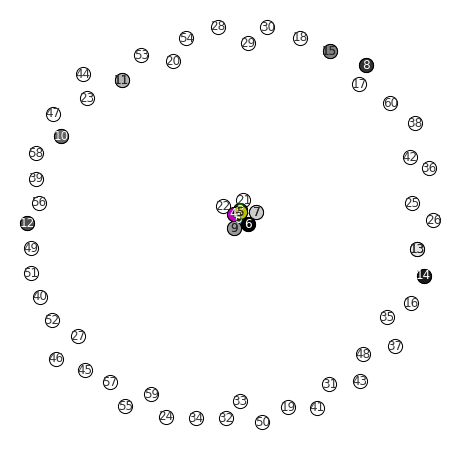

In [ ]:
viz.plot_community_graph(G, coms, plot_labels=True) # Plots how close each network community is to the others.

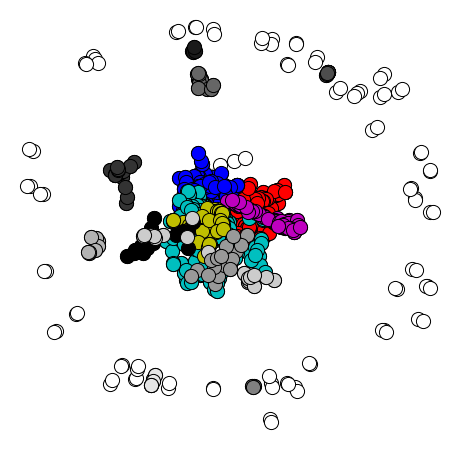

In [ ]:
viz.plot_network_clusters(G, coms) # Plots genes and networks, takes for fuckign ever and is actuallly less informative.

Next step is pulling just figuring out per network, how many are significant MR QTLs based on the supplemental materials of Nalls et al 2019. Something you could do pretty quick @Mary! Just cross reference each network's content from the community csv file with the table in the supplementals.

This could jus tbe something easy saying that each network contains x% signficant genes from the previous GWAS MRqtls study.

# Quick experiment to rerun everything excluding QTL nominated genes ... i.e. using only genes from RNA seq analyses.

In [ ]:
raw_df = pd.read_hdf("../mike_diff_exp/data_for_diff_exp.h5", key='diff_exp_df', mode='r')
case_df = raw_df[raw_df['PHENO'] == 1]
rna_df = pd.read_csv("rna_from_impMat.txt", engine='c', names=['gene_id'])
rna_gene_ids = rna_df['gene_id'].unique()
data_df = case_df[rna_gene_ids]

In [ ]:
# Quick imports.
# ! pip install cdlib
import networkx as nx
import community
from cdlib import algorithms, readwrite, evaluation, viz

In [ ]:
# Correlate the variables.
cor_matrix = data_df.iloc[:,1:].corr()
links = cor_matrix.stack().reset_index()
links.columns = ['feature1', 'feature2','corr']

In [ ]:
# filter at positve correlation > 0.8.
links_filtered = links.loc[ (links['corr'] >= 0.8) & (links['feature1'] != links['feature2']) ]

In [ ]:
# Make the networkx graph.
G=nx.from_pandas_edgelist(links_filtered, 'feature1', 'feature2')

In [ ]:
# Make the communities and export.
coms = algorithms.leiden(G)
readwrite.write_community_csv(coms, "all_samples_RNAseq_coms.csv")
readwrite.write_community_json(coms, "all_samples_RNAseq_coms.json")

In [ ]:
# Check modularity.
mod_eval = evaluation.erdos_renyi_modularity(G,coms)
print(str(mod_eval) + " a score of less than 0.5 is not great, 1 is theoretically perfect.")

FitnessResult(min=None, max=None, score=0.7941802381671127, std=None) a score of less than 0.5 is not great, 1 is theoretically perfect.


In [ ]:
pageranked = nx.pagerank(G)
pageranked_df = pd.DataFrame.from_dict(pageranked, orient='index')
pageranked_df.reset_index(level=0, inplace=True)
pageranked_df.rename(columns={"index":"feature_name",0:"page_rank"}, inplace=True)
pageranked_df.sort_values(by='page_rank', ascending=False, inplace=True)
pageranked_outfile = 'all_samples_RNAseq_pageranks.csv'
pageranked_df.to_csv(pageranked_outfile, index=False)
pageranked_df.head()

,feature_name,page_rank
107,ENSG00000116667,0.008679
175,ENSG00000089159,0.008639
180,ENSG00000179361,0.008216
138,ENSG00000115816,0.007996
136,ENSG00000107625,0.007718


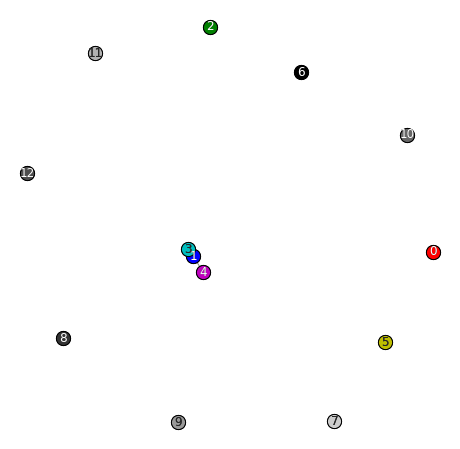

In [ ]:
viz.plot_community_graph(G, coms, plot_labels=True) # Plots how close each network community is to the others.

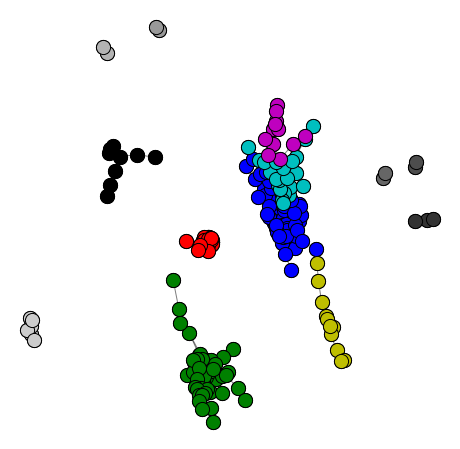

In [ ]:
viz.plot_network_clusters(G, coms) # Plots genes and networks, takes for fuckign ever and is actuallly less informative (sometimes).

# PPMI only baseline RNAseq derived networks. This gets us "peri-diagnostic" networks.

In [ ]:
raw_df = pd.read_hdf("../results/older_results/TEST_PPMI/PPMI_Only_Combined_Omics_v2.dataForML.h5", key='dataForML', mode='r')
case_df = raw_df[raw_df['PHENO'] == 1]
rna_df = pd.read_csv("rna_from_impMat.txt", engine='c', names=['gene_id'])
rna_gene_ids = rna_df['gene_id'].unique()

data_df = case_df[case_df.columns[case_df.columns.isin(rna_gene_ids)]]

In [ ]:
%%bash
pip install cdlib
pip install leidenalg
pip install python-igraph

In [ ]:
# Quick imports.
import leidenalg
import igraph
import networkx as nx
import community
from cdlib import algorithms, readwrite, evaluation, viz

In [ ]:
# Correlate the variables.
cor_matrix = data_df.iloc[:,1:].corr()
links = cor_matrix.stack().reset_index()
links.columns = ['feature1', 'feature2','corr']

In [ ]:
# filter at positve correlation > 0.8.
links_filtered = links.loc[ (links['corr'] >= 0.8) & (links['feature1'] != links['feature2']) ]

In [ ]:
# Make the networkx graph.
G=nx.from_pandas_edgelist(links_filtered, 'feature1', 'feature2')

In [ ]:
# Make the communities and export.
coms = algorithms.leiden(G)
readwrite.write_community_csv(coms, "PPMI_RNAseq_coms.csv")
readwrite.write_community_json(coms, "PPMI_RNAseq_coms.json")

In [ ]:
# Check modularity.
mod_eval = evaluation.erdos_renyi_modularity(G,coms)
print(str(mod_eval) + " a score of less than 0.5 is not great, 1 is theoretically perfect.")

FitnessResult(min=None, max=None, score=0.0, std=None) a score of less than 0.5 is not great, 1 is theoretically perfect.


In [ ]:
# Page rank it.
pageranked = nx.pagerank(G)
pageranked_df = pd.DataFrame.from_dict(pageranked, orient='index')
pageranked_df.reset_index(level=0, inplace=True)
pageranked_df.rename(columns={"index":"feature_name",0:"page_rank"}, inplace=True)
pageranked_df.sort_values(by='page_rank', ascending=False, inplace=True)
pageranked_outfile = 'PPMI_RNAseq_pageranks.csv'
pageranked_df.head()

,feature_name,page_rank
0,ENSG00000080824,0.5
1,ENSG00000086061,0.5


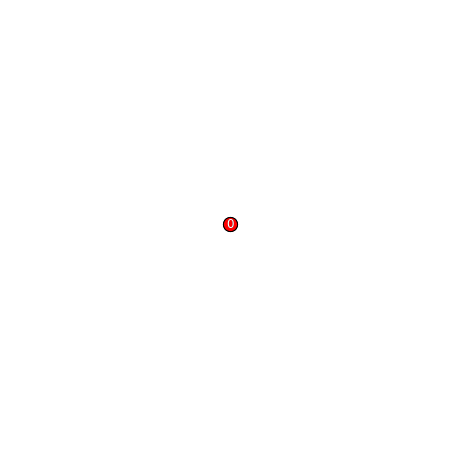

In [ ]:
# Plots how close each network community is to the others.
viz.plot_community_graph(G, coms, plot_labels=True) 

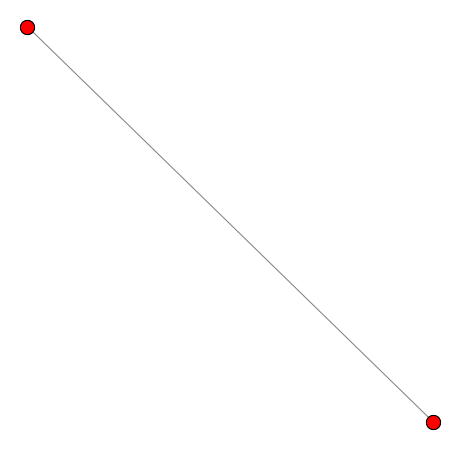

In [ ]:
# Plots genes and networks, takes for fuckign ever and is actuallly less informative.
viz.plot_network_clusters(G, coms) 

## Note, this dataset is too small. Zero modularity.

# Now we use the network set with the highest modularity score (QTLs and ENSG = 0.766, ENSGs only = 0.794), we want to: 
(1) see the rates of MR QTLs from the most recent PD GWAS per network community.
(2) see if high page rank genes are MR QTLs as well.
This will also give us some info for writing a paragraph in the results and a paragraph in the discussion.

In [ ]:
# Read in the QTLs from Nalls et al. 2019. Subset out to passing Bonferroni and merge on IDs of genes in the communities versus MR QTLs.
# This connects RNAseq to QTLs.
MR_qtls_raw_df = pd.read_csv("Table S6.  Complete summary statistics for QTL Mendelian randomization. - Sheet1.csv")
MR_qtls_df = MR_qtls_raw_df[['Probe','Gene','QTL reference','SMR, P']]

# Connect QTLs and Page ranks.
page_rank_df = pd.read_csv('all_samples_RNAseq_pageranks.csv')
annotated_page_rank_df = page_rank_df.merge(MR_qtls_df, left_on='feature_name', right_on='Probe', how='left')
annotated_page_rank_df.to_csv('all_samples_RNAseq_pageranks-QTL_annotated.csv', index=False)

# Quick question, is being a signficant QTL associated with higher page rank in the network?


# Connect QTLs and communities. Note, coms needs reformatting.
coms_raw_df = pd.read_csv('all_samples_RNAseq_coms.csv', header=None)
coms_raw_df['community'] = coms_raw_df.index

long_format = []
for column in coms_raw_df:
    column_content = coms_raw_df[column].tolist()
    long_format += column_content

long_format_df = pd.DataFrame(long_format)
long_format_df['COMMUNITY'] = [0,1,2,3,4,5,6,7,8,9,10,11,12]*87 # This is just a function of how many networks / rows, was lazy here.
long_format_df.columns=['feature_name','COMMUNITY']
long_format_df = long_format_df[long_format_df['feature_name'].str.contains('[A-Za-z]', na=False)]

annotated_long_format_df = long_format_df.merge(MR_qtls_df, left_on='feature_name', right_on='Probe', how='left')
annotated_long_format_df.to_csv('all_samples_RNAseq_coms-QTL_annotated.csv', index=False)


# Add gene symbol names to the networks to make people happy.

In [ ]:
# ! pip install pyensembl
# ! pyensembl install --release 100 --species human

import pyensembl
ensembl = pyensembl.EnsemblRelease(100)

annotated_long_format_df= pd.read_csv("all_samples_RNAseq_coms-QTL_annotated.csv")
annotated_page_rank_df = pd.read_csv("all_samples_RNAseq_pageranks-QTL_annotated.csv")

result = []
for value in annotated_long_format_df['feature_name']:
  result.append(ensembl.gene_name_of_gene_id(value))
annotated_long_format_df["gene_symbol"] = result

result = []
for value in annotated_page_rank_df['feature_name']:
  result.append(ensembl.gene_name_of_gene_id(value))
annotated_page_rank_df["gene_symbol"] = result


,feature_name,COMMUNITY,Probe,Gene,QTL reference,"SMR, P",gene_symbol
0,ENSG00000021488,0,NaN,NaN,NaN,NaN,SLC7A9
1,ENSG00000050130,1,NaN,NaN,NaN,NaN,JKAMP
2,ENSG00000010327,2,NaN,NaN,NaN,NaN,STAB1
3,ENSG00000001629,3,NaN,NaN,NaN,NaN,ANKIB1
4,ENSG00000062716,4,NaN,NaN,NaN,NaN,VMP1
...,...,...,...,...,...,...,...
295,ENSG00000183011,1,NaN,NaN,NaN,NaN,NAA38
296,ENSG00000159164,0,NaN,NaN,NaN,NaN,SV2A
297,ENSG00000105974,0,NaN,NaN,NaN,NaN,CAV1
298,ENSG00000184716,0,NaN,NaN,NaN,NaN,SERINC4


In [ ]:
# Let's also add MAGMA results for GWAS peak genes from Nalls et al 2019 and the differential expresison analysis (damn, sick of that nerd).

diff_exp_df = pd.read_csv("diff_exp_results_11022020 (1).csv")
magma_df = pd.read_csv("Table S7_ Rarer coding variant burden analyses for genes under GWAS peaks.csv")
diff_exp_df.columns=['feature_name','BETA_diff_exp','SE_diff_exp','P_diff_exp']

temp_df = annotated_long_format_df.merge(diff_exp_df, on='feature_name', how='left')
extra_annotated_long_format_df = temp_df.merge(magma_df, left_on='gene_symbol', right_on='Gene', how='left')

temp_df = annotated_page_rank_df.merge(diff_exp_df, on='feature_name', how='left')
extra_annotated_page_rank_df = temp_df.merge(magma_df, left_on='gene_symbol', right_on='Gene', how='left')


In [ ]:
# Export the extra annotations for page rank and summarize.
extra_annotated_page_rank_df.to_csv("all_samples_RNAseq_pageranks-QTL_annotated_MAGMA_diffexp.csv", index=False)
extra_annotated_page_rank_df.describe()

,page_rank,"SMR, P",BETA_diff_exp,SE_diff_exp,P_diff_exp,"N variants, MAF < 5%","Q, MAF < 5%","Rho, MAF < 5%","P, MAF < 5%","N variants, MAF < 1%","Q, MAF < 1%","Rho, MAF < 1%","P, MAF < 1%","Bonferroni corrected P, MAF < 5%","Bonferroni corrected P, MAF < 1%"
count,300.000000,2.000000e+00,300.000000,300.000000,3.000000e+02,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.00000,1.0,1.000000
mean,0.003333,5.728252e-03,0.125346,0.436580,3.170247e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
std,0.001549,8.100457e-03,1.472771,0.140984,2.916151e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000544,3.640000e-07,-3.827790,0.118315,3.775474e-09,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
25%,0.002194,2.864308e-03,-1.280981,0.346064,4.414016e-04,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
50%,0.003412,5.728252e-03,0.866710,0.438764,2.509674e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
75%,0.003855,8.592196e-03,1.379752,0.516894,5.242978e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
max,0.008679,1.145614e-02,2.829808,0.867891,9.922232e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772


In [ ]:
# Export the extra annotations for networks and summarize.
extra_annotated_long_format_df.to_csv("all_samples_RNAseq_coms-QTL_annotated_MAGMA_diffexp.csv", index=False)
extra_annotated_long_format_df.describe()

,COMMUNITY,"SMR, P",BETA_diff_exp,SE_diff_exp,P_diff_exp,"N variants, MAF < 5%","Q, MAF < 5%","Rho, MAF < 5%","P, MAF < 5%","N variants, MAF < 1%","Q, MAF < 1%","Rho, MAF < 1%","P, MAF < 1%","Bonferroni corrected P, MAF < 5%","Bonferroni corrected P, MAF < 1%"
count,300.000000,2.000000e+00,300.000000,300.000000,3.000000e+02,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.00000,1.0,1.000000
mean,1.950000,5.728252e-03,0.125346,0.436580,3.170247e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
std,2.307651,8.100457e-03,1.472771,0.140984,2.916151e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,3.640000e-07,-3.827790,0.118315,3.775474e-09,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
25%,0.000000,2.864308e-03,-1.280981,0.346064,4.414016e-04,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
50%,1.000000,5.728252e-03,0.866710,0.438764,2.509674e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
75%,3.000000,8.592196e-03,1.379752,0.516894,5.242978e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772
max,12.000000,1.145614e-02,2.829808,0.867891,9.922232e-03,4.0,74125.0,0.0,0.414,2.0,50440.6,0.1,0.00576,1.0,0.552772


# We want to look at drug annotation enrichment.
Make a list of the 300 network genes and then a list of protein codign genes excluding those.

In [ ]:
# Load up the gene lists.
all_protein_coding_df = pd.read_csv("proteincodinggenes.txt", engine='c')
network_comm_genes_df = pd.read_csv("all_samples_RNAseq_coms-QTL_annotated_MAGMA_diffexp.csv", engine='c')

network_gene_list = network_comm_genes_df['feature_name'].unique()

background_df = all_protein_coding_df[~all_protein_coding_df['Gene'].isin(network_gene_list)]

network_comm_genes_df['feature_name'].to_csv("network_drugbank_genes_df.txt", index=False, header=False)
background_df.to_csv("background_drugbank_genes_df.txt", index=False, header=False) # useless, already availible as a background. other gene list for comparison is rna_from_impMat.txt.